In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_experiments.library.tomography import ProcessTomography, StateTomography
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeKyoto
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import Chi, Choi, Kraus, SuperOp
import numpy as np
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment
import gen_funcs
import csv
from qiskit.primitives import BackendEstimator
from post_proc_funcs import * # compute_intmdt_maps, compute_Nrhp
from gen_funcs import * 


In [2]:
# from qiskit_ibm_runtime import QiskitRuntimeService
import os
# from qiskit_ibm_provider import IBMProvider

# # Save your credentials on disk.
# IBMProvider.save_account(token=)
# provider = IBMProvider(instance='usc/phys550/phys550')



from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='usc/phys550/phys550',
    token=os.environ.get('QISKIT_IBM_TOKEN')
)


In [3]:
backend = service.backend("ibm_torino")
# backend = service.backend("ibm_kyoto")
# backend = service.backend("simulator_stabilizer")
# backend = service.least_busy(operational=True, simulator=False)
backend

<IBMBackend('ibm_torino')>

In [4]:
backend.num_qubits

133

In [5]:
# simulator = AerSimulator.from_backend(FakeKyoto())
# ns_simulator = AerSimulator.from_backend(GenericBackendV2(num_qubits=2))

In [6]:
base_circ = QuantumCircuit(1)
base_circ.id(0)
base_circ.id(0)
base_circ.id(0)
base_circ.draw()

┌───┐┌───┐┌───┐
q: ┤ I ├┤ I ├┤ I ├
   └───┘└───┘└───┘

In [8]:
temp = QuantumCircuit(1)
temp.x(0)
other = QuantumCircuit(1)
other.id(0)
other = other.repeat(2)

In [5]:
n_qubits = 127
# circ_ls = gen_circ_ls(base_circ, n_qubits)
circ_ls_0 = gen_delay_circ_ls(1, n_qubits, total_us_time=n_qubits,start_state='0')
circ_ls_1 = gen_delay_circ_ls(1, n_qubits, total_us_time=n_qubits,start_state='1')
circ_ls_plus = gen_delay_circ_ls(1, n_qubits, total_us_time=n_qubits,start_state='+')
circ_ls_minus = gen_delay_circ_ls(1, n_qubits, total_us_time=n_qubits,start_state='-')
circ_ls_plus_i = gen_delay_circ_ls(1, n_qubits, total_us_time=n_qubits,start_state='+i')
circ_ls_minus_i = gen_delay_circ_ls(1, n_qubits, total_us_time=n_qubits,start_state='-i')
qubit_ls = gen_funcs.gen_qubit_ls(n_qubits, 1, repeat=False)

In [6]:
print(len(circ_ls_0), len(qubit_ls))
print("====================")
print(circ_ls_0[0],qubit_ls[0])
print("====================")
print(circ_ls_0[-1],qubit_ls[-1])

127 127
   ┌────────────────┐
q: ┤ Delay(1.0[us]) ├
   └────────────────┘ [0]
   ┌──────────────────┐
q: ┤ Delay(127.0[us]) ├
   └──────────────────┘ [126]


In [7]:
parallel_spt_0 = parallel_exp_1q2q(circ_ls_0, backend, qubit_ls, state_tom=True, mitigation=True)
parallel_spt_1 = parallel_exp_1q2q(circ_ls_1, backend, qubit_ls, state_tom=True, mitigation=True)
parallel_spt_plus = parallel_exp_1q2q(circ_ls_plus, backend, qubit_ls, state_tom=True, mitigation=True)
parallel_spt_minus = parallel_exp_1q2q(circ_ls_minus, backend, qubit_ls, state_tom=True, mitigation=True)
parallel_spt_plus_i = parallel_exp_1q2q(circ_ls_plus_i, backend, qubit_ls, state_tom=True, mitigation=True)
parallel_spt_minus_i = parallel_exp_1q2q(circ_ls_minus_i, backend, qubit_ls, state_tom=True, mitigation=True)

In [8]:
parallel_result_plus = parallel_spt_plus.run(backend=backend)
parallel_result_minus = parallel_spt_minus.run(backend=backend)
parallel_result_0 = parallel_spt_0.run(backend=backend)
parallel_result_1 = parallel_spt_1.run(backend=backend)
parallel_result_plus_i = parallel_spt_plus_i.run(backend=backend)
parallel_result_minus_i = parallel_spt_minus_i.run(backend=backend)

In [9]:
print(parallel_result_0.status(), parallel_result_1.status(), parallel_result_plus.status(), parallel_result_minus.status(), parallel_result_plus_i.status(), parallel_result_minus_i.status())

ExperimentStatus.DONE ExperimentStatus.DONE ExperimentStatus.DONE ExperimentStatus.DONE ExperimentStatus.DONE ExperimentStatus.DONE


In [10]:
print(parallel_result_0.child_data()[0].analysis_results(dataframe=1))
print(parallel_result_1.child_data()[0].analysis_results(dataframe=1))
print(parallel_result_plus.child_data()[0].analysis_results(dataframe=1))
print(parallel_result_minus.child_data()[0].analysis_results(dataframe=1))
print(parallel_result_plus_i.child_data()[0].analysis_results(dataframe=1))
print(parallel_result_minus_i.child_data()[0].analysis_results(dataframe=1))

                             name         experiment components  \
6bb4a6d0                    state    StateTomography       [Q0]   
9ae75aff           state_fidelity    StateTomography       [Q0]   
13c23234                 positive    StateTomography       [Q0]   
a7e5ebd9  Local Readout Mitigator  LocalReadoutError       [Q0]   

                                                      value quality  \
6bb4a6d0  DensityMatrix([[0.91866029+0.j        , 0.0164...    None   
9ae75aff                                            0.91866    None   
13c23234                                               True    None   
a7e5ebd9  <qiskit.result.mitigation.local_readout_mitiga...    None   

             backend run_time trace  \
6bb4a6d0  ibm_torino     None   1.0   
9ae75aff  ibm_torino     None  None   
13c23234  ibm_torino     None  None   
a7e5ebd9  ibm_torino     None  None   

                                            eigvals  \
6bb4a6d0  [0.9206555023893209, 0.07934449761068013]   
9a

In [11]:
print(parallel_result_0.child_data()[-1].analysis_results(dataframe=1))
print(parallel_result_1.child_data()[-1].analysis_results(dataframe=1))
print(parallel_result_plus.child_data()[-1].analysis_results(dataframe=1))
print(parallel_result_minus.child_data()[-1].analysis_results(dataframe=1))
print(parallel_result_plus_i.child_data()[-1].analysis_results(dataframe=1))
print(parallel_result_minus_i.child_data()[-1].analysis_results(dataframe=1))

                             name         experiment components  \
fe916258                    state    StateTomography     [Q126]   
e0f648ba           state_fidelity    StateTomography     [Q126]   
8f9f44a2                 positive    StateTomography     [Q126]   
a985df5c  Local Readout Mitigator  LocalReadoutError     [Q126]   

                                                      value quality  \
fe916258  DensityMatrix([[0.97005805+0.j       , 0.00259...    None   
e0f648ba                                           0.970058    None   
8f9f44a2                                               True    None   
a985df5c  <qiskit.result.mitigation.local_readout_mitiga...    None   

             backend run_time trace  \
fe916258  ibm_torino     None   1.0   
e0f648ba  ibm_torino     None  None   
8f9f44a2  ibm_torino     None  None   
a985df5c  ibm_torino     None  None   

                                            eigvals  \
fe916258  [0.9701111207919132, 0.02988887920808857]   
e0

In [13]:
def get_array_from_dataframe(df):
    return [df.child_data()[i].analysis_results(dataframe=1)['value'][0].data for i in range(len(df.child_data()))]
results_0 = get_array_from_dataframe(parallel_result_0)
results_1 = get_array_from_dataframe(parallel_result_1)
results_plus = get_array_from_dataframe(parallel_result_plus)
results_minus = get_array_from_dataframe(parallel_result_minus)
results_plus_i = get_array_from_dataframe(parallel_result_plus_i)
results_minus_i = get_array_from_dataframe(parallel_result_minus_i)

/var/folders/8r/fcck2fx56mz4lc18dwtykgtw0000gn/T/ipykernel_5240/117862749.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [df.child_data()[i].analysis_results(dataframe=1)['value'][0].data for i in range(len(df.child_data()))]
/var/folders/8r/fcck2fx56mz4lc18dwtykgtw0000gn/T/ipykernel_5240/117862749.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [df.child_data()[i].analysis_results(dataframe=1)['value'][0].data for i in range(len(df.child_data()))]
/var/folders/8r/fcck2fx56mz4lc18dwtykgtw0000gn/T/ipykernel_5240/117862749.py:2: FutureWarning: Series.__getitem__ treating keys as positions is depr

In [14]:
# import pickle
# states = ['zero','one','plus','minus','plus_i','minus_i']
# results = [results_0,results_1,results_plus,results_minus,results_plus_i,results_minus_i]

# for i,state in enumerate(states):
#     file_path = f'data/np_{state}_mitigated_state_tomography_single.pickle'
#     # Open the file in binary mode
#     with open(file_path, 'wb') as file:
#         # Serialize and write the variable to the file
#         pickle.dump(results[i], file)

In [31]:
results_0[0]

DensityMatrix([[0.8865+0.j   , 0.0455-0.036j],
               [0.0455+0.036j, 0.1135+0.j   ]],
              dims=(2,))


In [23]:
# input the file data 
import pickle
state_names = ['zero','one','plus','minus','plus_i','minus_i']
mitigated_base_filename = lambda state: f'data/np_{state}_mitigated_state_tomography_single.pickle'
base_filename = lambda state: f'data/np_{state}_state_tomography_single.pickle'
mitigated_results = {state: pickle.load(open(mitigated_base_filename(state), 'rb')) for state in state_names}
normal_results = {state: pickle.load(open(base_filename(state), 'rb')) for state in state_names}

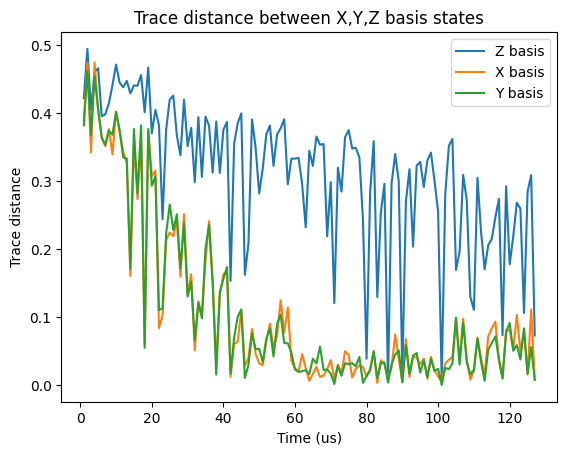

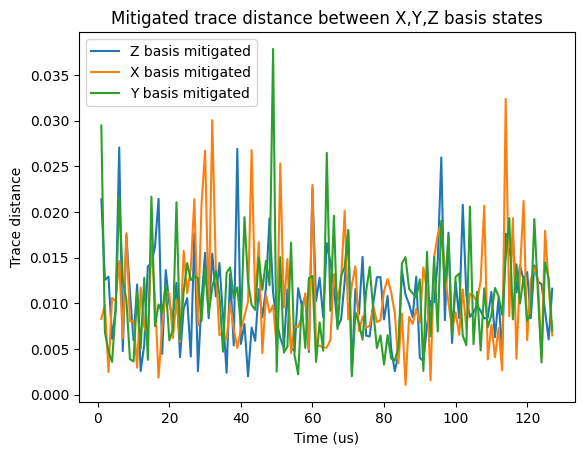

In [25]:
# trace distance plot
def trace_distance_helper(rho1, rho2):
    rho1 = np.array(rho1)
    rho2 = np.array(rho2)
    return 0.5 * np.linalg.norm(rho1 - rho2, ord=1)
def get_trace_distance_list(data1,data2):
    new_data = []
    for i in range(len(data1)):
        new_data.append(trace_distance_helper(data1[i],data2[i]))
    return new_data

trace_distance_Z = get_trace_distance_list(normal_results['zero'],normal_results['one'])
mitigated_trace_distance_Z = get_trace_distance_list(mitigated_results['zero'],mitigated_results['one'])
trace_distance_X = get_trace_distance_list(normal_results['plus'],normal_results['minus'])
mitigated_trace_distance_X = get_trace_distance_list(mitigated_results['plus'],mitigated_results['minus'])
trace_distance_Y = get_trace_distance_list(normal_results['plus_i'],normal_results['minus_i'])
mitigated_trace_distance_Y = get_trace_distance_list(mitigated_results['plus_i'],mitigated_results['minus_i'])

time = []

dt = round(n_qubits/n_qubits,1)
t = dt
while t <= n_qubits:
    time.append(t)
    t += dt

from matplotlib import pyplot as plt

plt.plot(time, trace_distance_Z, label='Z basis')
plt.plot(time, trace_distance_X, label='X basis')
plt.plot(time, trace_distance_Y, label='Y basis')
plt.title('Trace distance between X,Y,Z basis states')
plt.xlabel('Time (us)')
plt.ylabel('Trace distance')
plt.legend()
plt.show()


plt.plot(time, mitigated_trace_distance_Z, label='Z basis mitigated')
plt.plot(time, mitigated_trace_distance_X, label='X basis mitigated')
plt.plot(time, mitigated_trace_distance_Y, label='Y basis mitigated')
plt.title('Mitigated trace distance between X,Y,Z basis states')
plt.xlabel('Time (us)')
plt.ylabel('Trace distance')
plt.legend()
plt.show()

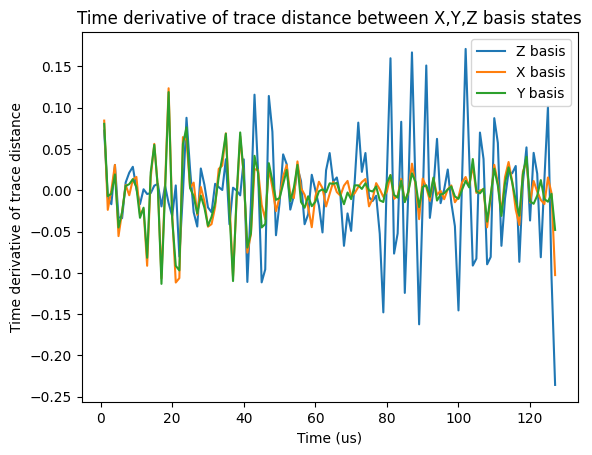

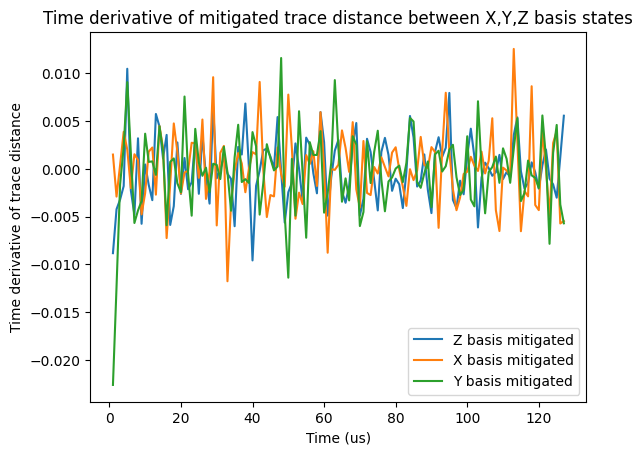

In [26]:
# time derivative of the trace distance
dt_trace_distance_Z = np.gradient(trace_distance_Z, dt)
dt_trace_distance_X = np.gradient(trace_distance_X, dt)
dt_trace_distance_Y = np.gradient(trace_distance_Y, dt)
dt_mitigated_trace_distance_Z = np.gradient(mitigated_trace_distance_Z, dt)
dt_mitigated_trace_distance_X = np.gradient(mitigated_trace_distance_X, dt)
dt_mitigated_trace_distance_Y = np.gradient(mitigated_trace_distance_Y, dt)

plt.plot(time, dt_trace_distance_Z, label='Z basis')
plt.plot(time, dt_trace_distance_X, label='X basis')
plt.plot(time, dt_trace_distance_Y, label='Y basis')
plt.title('Time derivative of trace distance between X,Y,Z basis states')
plt.xlabel('Time (us)')
plt.ylabel('Time derivative of trace distance')
plt.legend()
plt.show()

plt.plot(time, dt_mitigated_trace_distance_Z, label='Z basis mitigated')
plt.plot(time, dt_mitigated_trace_distance_X, label='X basis mitigated')
plt.plot(time, dt_mitigated_trace_distance_Y, label='Y basis mitigated')
plt.title('Time derivative of mitigated trace distance between X,Y,Z basis states')
plt.xlabel('Time (us)')
plt.ylabel('Time derivative of trace distance')
plt.legend()
plt.show()

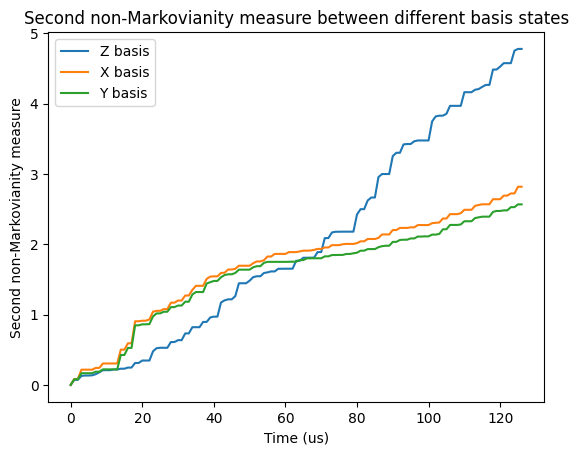

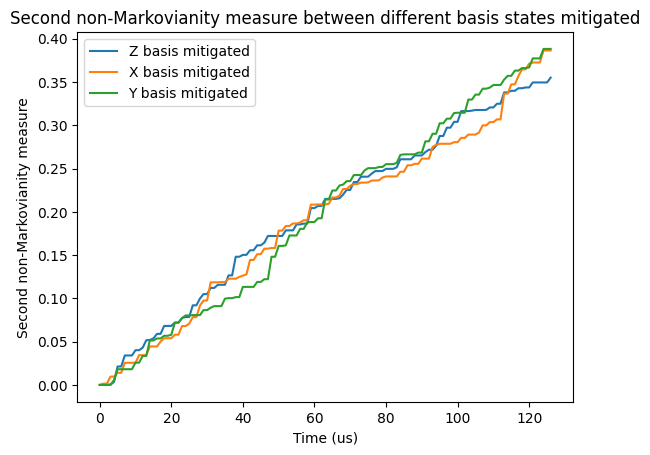

In [28]:
def second_non_markovian_helper_function(states):
    """
    States must be a list of density matrices of the system at different times.
    basis_states[i] = [[p_{1,i} (t1), p_{2,i} (t1)], [p_{1,i} (t2), p_{2,i} (t2)], ...]
    basis_states[i] are in some basis {X,Y,Z}

    states = [basis_states[X], basis_states[Y], basis_states[Z]]
    """
    basis_values = [0,0,0] # basis values for [X,Y,Z]
    intermediate_tot_measures = [[0],[0],[0]]

    for basis, basis_states in enumerate(states):
        n = len(basis_states)
        for i in range(0,n-1,1):
            before = trace_distance_helper(basis_states[i][0],basis_states[i][1])
            after = trace_distance_helper(basis_states[i+1][0],basis_states[i+1][1])
            sigma = after - before # derivative of trace distance
            basis_values[basis] += max(sigma,0)
            intermediate_tot_measures[basis].append(basis_values[basis])
    max_val = max(basis_values)
    # find index of max of basis_values
    max_index = basis_values.index(max_val)
    return intermediate_tot_measures[max_index]

# plot the second non-Markovianity measure
def second_non_markovian_measure(states):
    """
    Compute the second non-Markovianity measure of a quantum process.
    Args:
        states (list): List of states of the quantum process from a given basis
    """
    integral_sum = 0
    intermediate_measures = [0]

    for i in range(len(states)-1):
        before = trace_distance_helper(states[i][0], states[i][1])
        after = trace_distance_helper(states[i+1][0], states[i+1][1])
        sigma = after - before # derivative of trace distance
        integral_sum += max(sigma,0)
        intermediate_measures.append(integral_sum)
    return integral_sum, intermediate_measures

Z_basis = list(zip(normal_results['zero'],normal_results['one']))
X_basis = list(zip(normal_results['plus'],normal_results['minus']))
Y_basis = list(zip(normal_results['plus_i'],normal_results['minus_i']))
Z_basis_mitigated = list(zip(mitigated_results['zero'],mitigated_results['one']))
X_basis_mitigated = list(zip(mitigated_results['plus'],mitigated_results['minus']))
Y_basis_mitigated = list(zip(mitigated_results['plus_i'],mitigated_results['minus_i']))
_,N_second_markovianity_Z = second_non_markovian_measure(Z_basis)
_,N_second_markovianity_X = second_non_markovian_measure(X_basis)
_,N_second_markovianity_Y = second_non_markovian_measure(Y_basis)
_,N_second_markovianity_Z_mitigated = second_non_markovian_measure(Z_basis_mitigated)
_,N_second_markovianity_X_mitigated = second_non_markovian_measure(X_basis_mitigated)
_,N_second_markovianity_Y_mitigated = second_non_markovian_measure(Y_basis_mitigated)

# temp = [Z_basis,X_basis,Y_basis]
# print(np.array(temp).shape)
# total_second_markovianity_measure = second_non_markovian_helper_function(temp)

new_time = np.arange(0,len(results_0),1)

plt.plot(new_time, N_second_markovianity_Z, label='Z basis')
plt.plot(new_time, N_second_markovianity_X, label='X basis')
plt.plot(new_time, N_second_markovianity_Y, label='Y basis')
plt.title('Second non-Markovianity measure between different basis states')
plt.xlabel('Time (us)')
plt.ylabel('Second non-Markovianity measure')
plt.legend()
plt.show()

plt.plot(new_time, N_second_markovianity_Z_mitigated, label='Z basis mitigated')
plt.plot(new_time, N_second_markovianity_X_mitigated, label='X basis mitigated')
plt.plot(new_time, N_second_markovianity_Y_mitigated, label='Y basis mitigated')
plt.title('Second non-Markovianity measure between different basis states mitigated')
plt.xlabel('Time (us)')
plt.ylabel('Second non-Markovianity measure')
plt.legend()
plt.show()


In [29]:
# # save the data of the non-mitigated data
# import pickle
# file_path = f'data/second_non_markovianity_measure_Z_basis.pickle'
# # Open the file in binary mode
# with open(file_path, 'wb') as file:
#     # Serialize and write the variable to the file
#     pickle.dump(N_second_markovianity_Z, file)
# file_path = f'data/second_non_markovianity_measure_X_basis.pickle'
# # Open the file in binary mode
# with open(file_path, 'wb') as file:
#     # Serialize and write the variable to the file
#     pickle.dump(N_second_markovianity_X, file)